In [2]:
# These settings are for the notebook only
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [53]:
# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Import the required modules from the magrec package
from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.transformation.Mxy2Bsensor import Mxy2Bsensor
from magrec.method.CNN import CNN
from magrec.method.FCNN import FCNN
from magrec.models.UniformMagnetisation import UniformMagnetisation
from magrec.misc.data import Data
from magrec import __datapath__

C:\Users\E123108\AppData\Local\Temp\ipykernel_35016\4169351350.py:15: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, BNV, kind='linear')
C:\Users\E123108\AppData\Local\Temp\ipykernel_35016\4169351350.py:18: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev

Applied a high frequency filter, removing all components smaller than 0.05 um


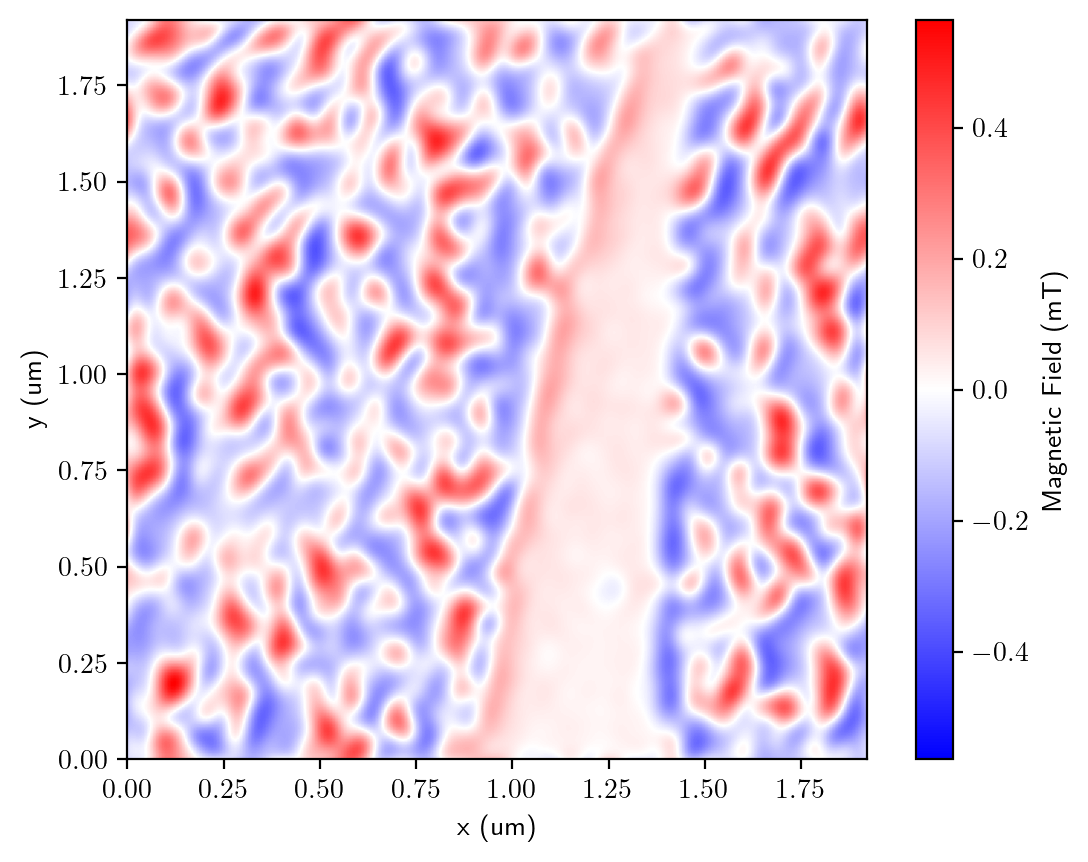

In [71]:
# Load the data from the database
f = open(__datapath__ / "Mz" / "MoirePatten_Stuttgart.lvm")
data = np.loadtxt(f).reshape(100,800)

# Convert the data into a magnetic field
BNV = 1e-6 *data[::,0:400] / (2.8e4)
# measured pixel size
dx = 3/400
dy = 3/100

# The data has an uneven number of points in the x and y direction
# This is can cause issues witht the reconstruction so we 
# interpolate the data to a regular grid
x = np.linspace(0,3,400)
y = np.linspace(0,3,100)
f = interpolate.interp2d(x, y, BNV, kind='linear')
xnew = np.linspace(0,3,256)
ynew = np.linspace(0,3,256)
BNV = f(xnew, ynew)


# updated pixel size
dx = 3/len(xnew)
dy = 3/len(ynew)


# Define the sensor parameters
sensor_theta = 53
sensor_phi = 282
height = 50e-3 # um
layer_thickness = 0

# initalise the dataset object and load the data
dataset = Data()
dataset.load_data(BNV, dx, dy, height, sensor_theta, sensor_phi, layer_thickness)

# Add spatial filters and perform other actions on the dataset 
dataset.add_hanning_filter(height)
dataset.add_short_wavelength_filter(height)
dataset.remove_DC_background()
# dataset.crop_data([0,256,0,256])
# dataset.pad_data_to_power_of_two()
dataset.plot_target()

In [72]:
# Display all of the actions that have been performed on the data
dataset.actions

action type  reverseable reverse action  \
0                load_data        False           None   
1           hanning_filter        False           None   
2  short_wavelength_filter        False           None   
3     remove_DC_background        False           None   

                                         description         parameters  
0                                    loaded the data               None  
1  Applied a low frequency filter, removing all c...  wavelength = 0.05  
2  Applied a high frequency filter, removing all ...  wavelength = 0.05  
3            Removed the DC background from the data               None

# Transform Bsensor into Bxyz

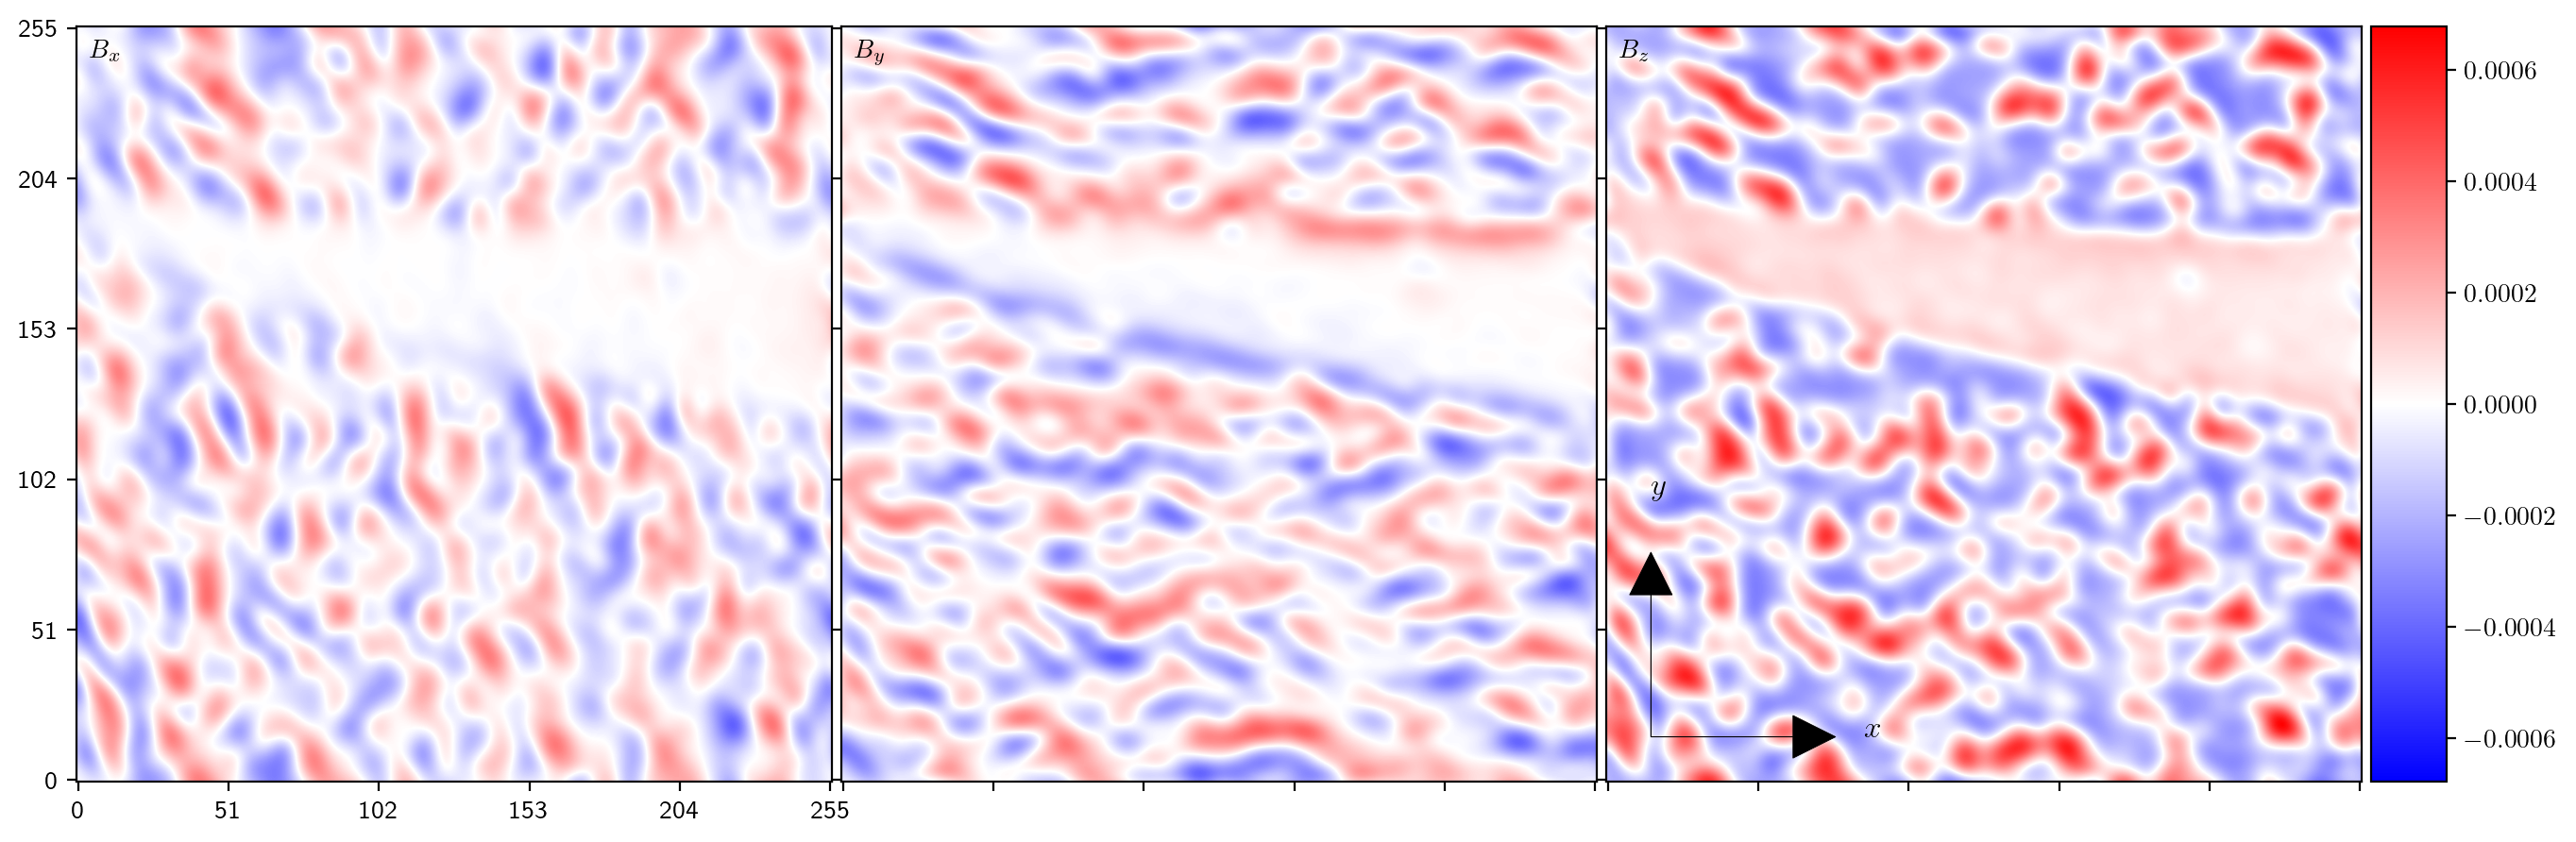

In [73]:
# Set the transformation to be performed on the data
dataset.set_transformer(MagneticFields)
# Perform the transformation
dataset.transform_data()

# Define the Bz data from the bx, by, and bz recontruction
Bx_data = dataset.transformed_target[0,::]
By_data = dataset.transformed_target[1,::]
Bz_data = dataset.transformed_target[2,::]

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

# Reconstruction of magnetisation with different approaches

Applied a high frequency filter, removing all components smaller than 0.05 um
no input provided, using the dataset target


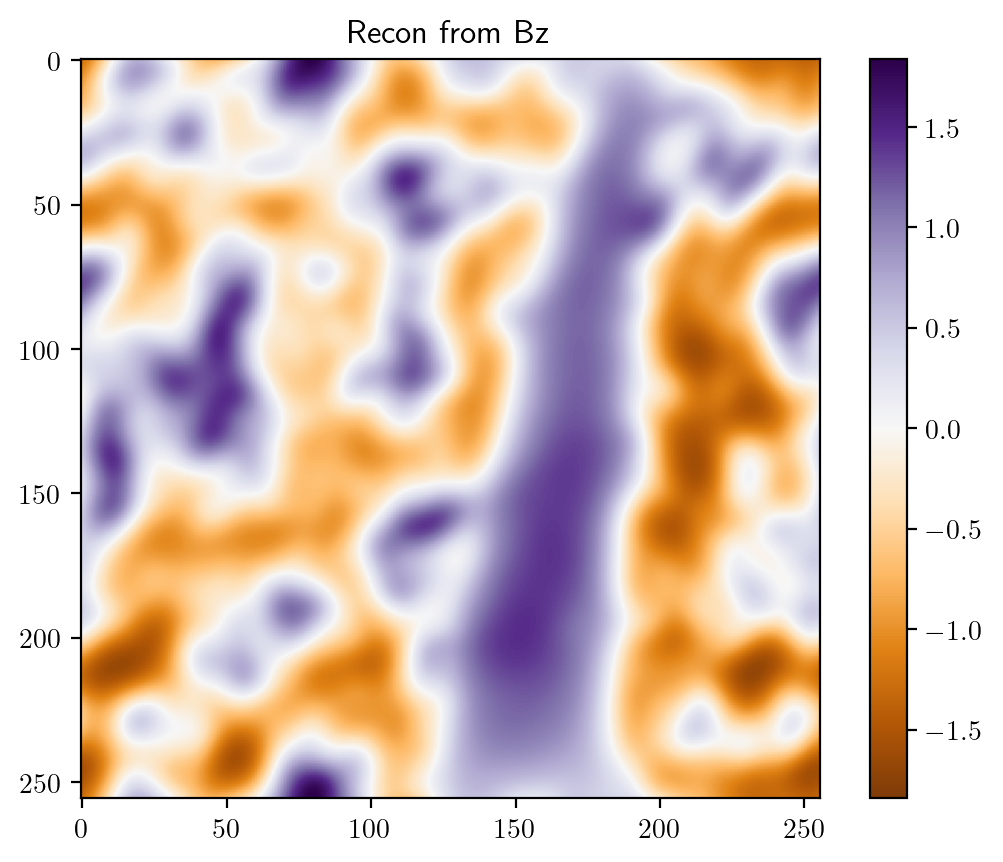

In [74]:
# Define a new dataset object for the reconstruction
Frecon_dataset = Data()
Frecon_dataset.load_data(Bz_data, dx, dy, height, 0, 0, 0)

# Set the transformation to be performed on the data
Frecon_dataset.set_transformer(Bsensor2Mxy, m_theta = 0, m_phi =0)
# Perform the transformation
Frecon_dataset.transform_data()

c_range = np.nanmax(np.abs(Frecon_dataset.transformed_target))

# Plot the reconstructed result
plt.figure()
plt.imshow(-1*Frecon_dataset.transformed_target, cmap="PuOr", vmin=-c_range, vmax = c_range)
plt.title("Recon from Bz")
plt.colorbar()


## Reconstruction with CNN

In [57]:
# make a new dataset object for the reconstruction
NN_recon_data = Data()
NN_recon_data.load_data(Bz_data, 
                        dx = dx, 
                        dy = dy, 
                        height = height, 
                        theta = 0, 
                        phi = 0, 
                        layer_thickness = 0)

# Define the model of the source that will be reconstructed
Model = UniformMagnetisation(NN_recon_data, 
                             loss_type = "MSE", 
                             m_theta = 0, 
                             m_phi = 0,
                             scaling_factor = 1e6,
                             source_weight = None,
                             loss_weight = None, )

# Define the fitting method and pass it the model
FittingMethod = CNN(Model, learning_rate = 0.1)

Number of sources: 1
Number of targets: 1


epoch     1 | loss on last mini-batch:  4.85e+10
epoch    11 | loss on last mini-batch:  1.30e+13
epoch    21 | loss on last mini-batch:  1.57e+11
epoch    31 | loss on last mini-batch:  1.26e+12
epoch    41 | loss on last mini-batch:  3.43e+11
epoch    51 | loss on last mini-batch:  9.28e+10
epoch    61 | loss on last mini-batch:  1.66e+10
epoch    71 | loss on last mini-batch:  1.95e+10
epoch    81 | loss on last mini-batch:  4.96e+09
epoch    91 | loss on last mini-batch:  4.91e+09
epoch   101 | loss on last mini-batch:  3.15e+09
epoch   111 | loss on last mini-batch:  2.38e+09
epoch   121 | loss on last mini-batch:  2.02e+09
epoch   131 | loss on last mini-batch:  1.71e+09
epoch   141 | loss on last mini-batch:  1.47e+09
epoch   151 | loss on last mini-batch:  1.28e+09
epoch   161 | loss on last mini-batch:  1.14e+09
epoch   171 | loss on last mini-batch:  1.01e+09
epoch   181 | loss on last mini-batch:  9.13e+08
epoch   191 | loss on last mini-batch:  8.30e+08


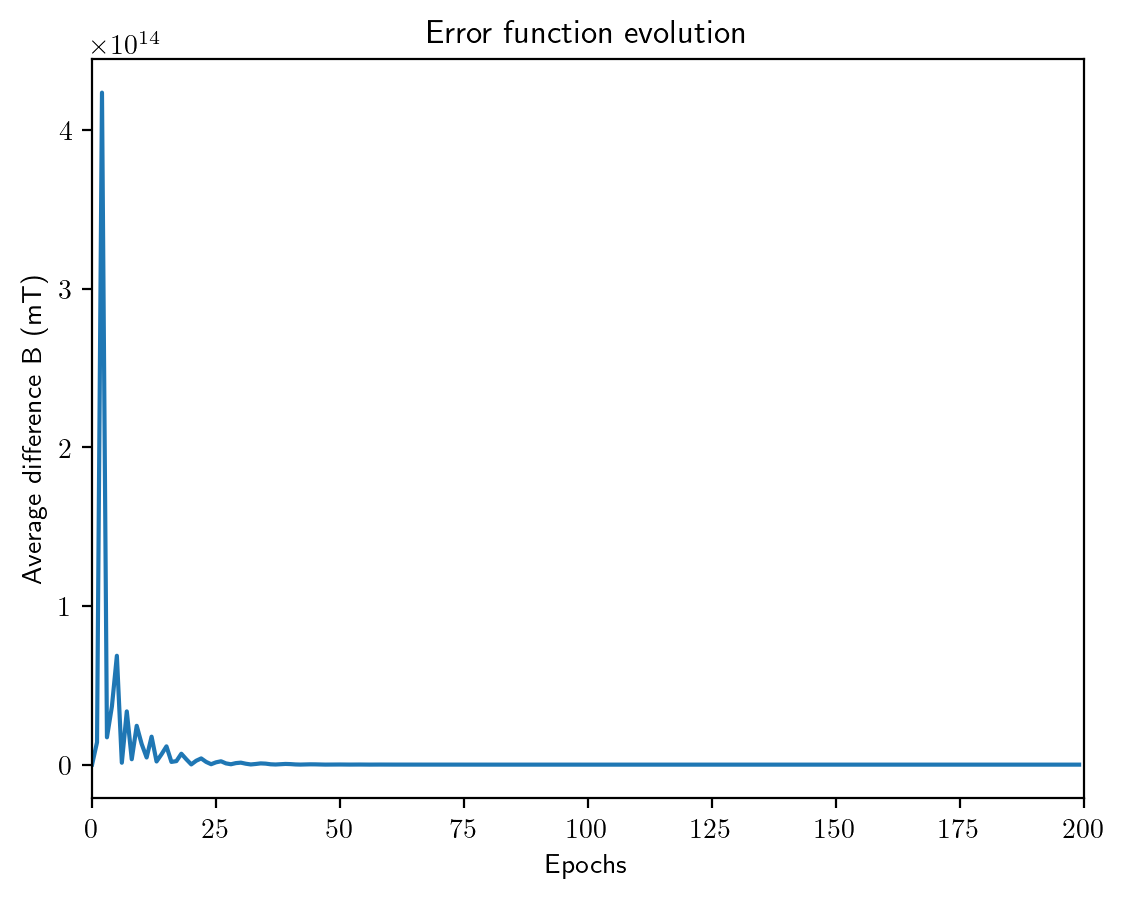

In [58]:
# Perform the fit using the NN
FittingMethod.fit(n_epochs=200)
# Plot the exvolution of the loss function
FittingMethod.plot_loss()

Removed the padding that was applied to the data


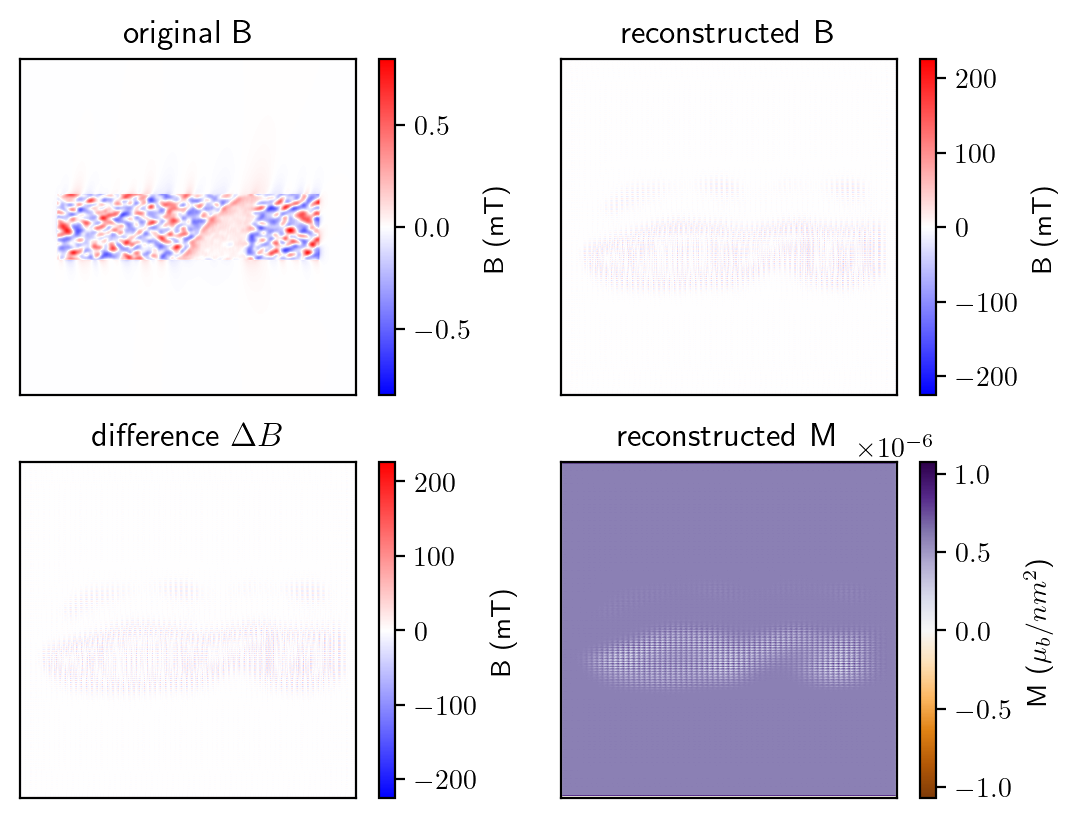

In [59]:
# Plot the results of the reconstruction
FittingMethod.plot_results()

## 5. Reconstruction with CNN and a Source Mask

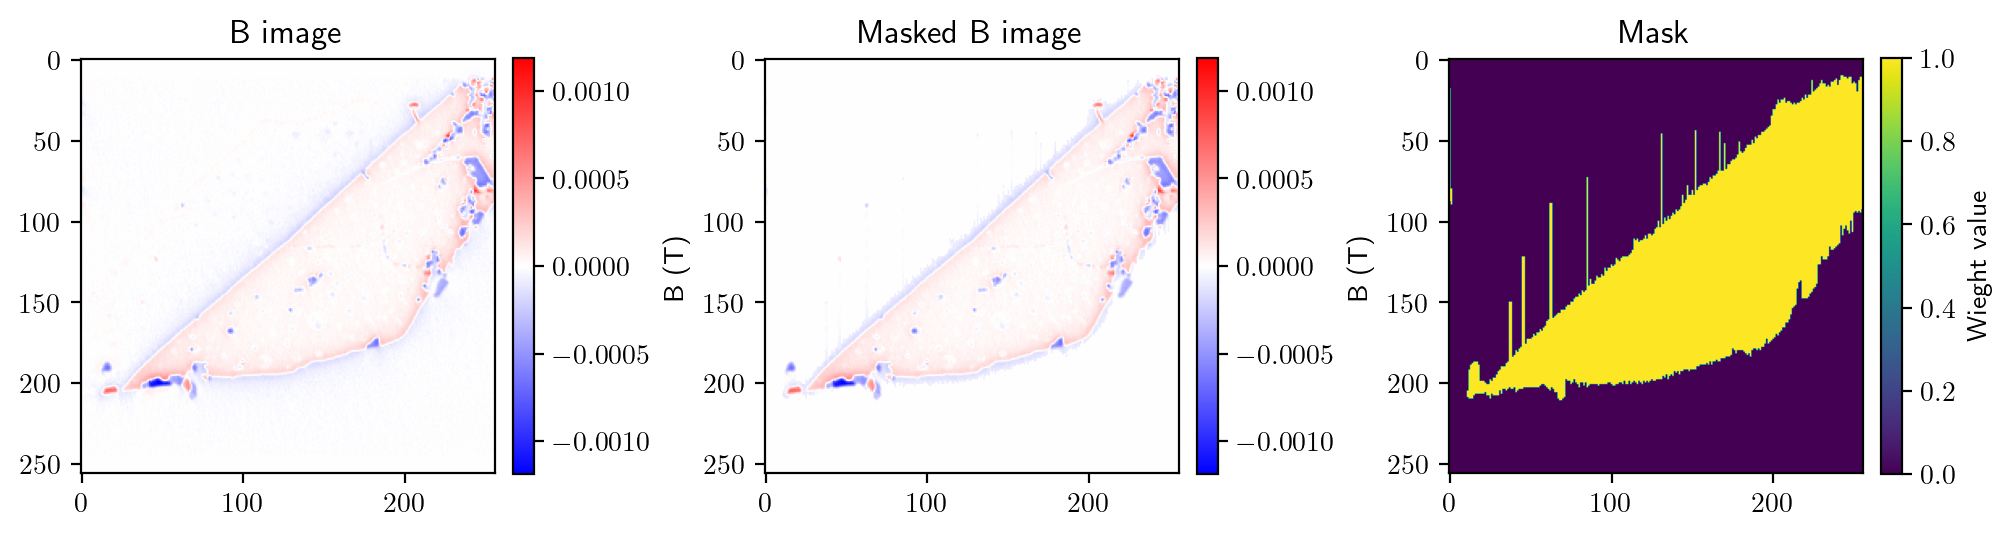

In [41]:
threshold = 0.8e-4
source_weight = masks.mask_vert_dir(dataset.transformed_target[2,::], threshold, plot = True)


Number of sources: 1
Number of targets: 1


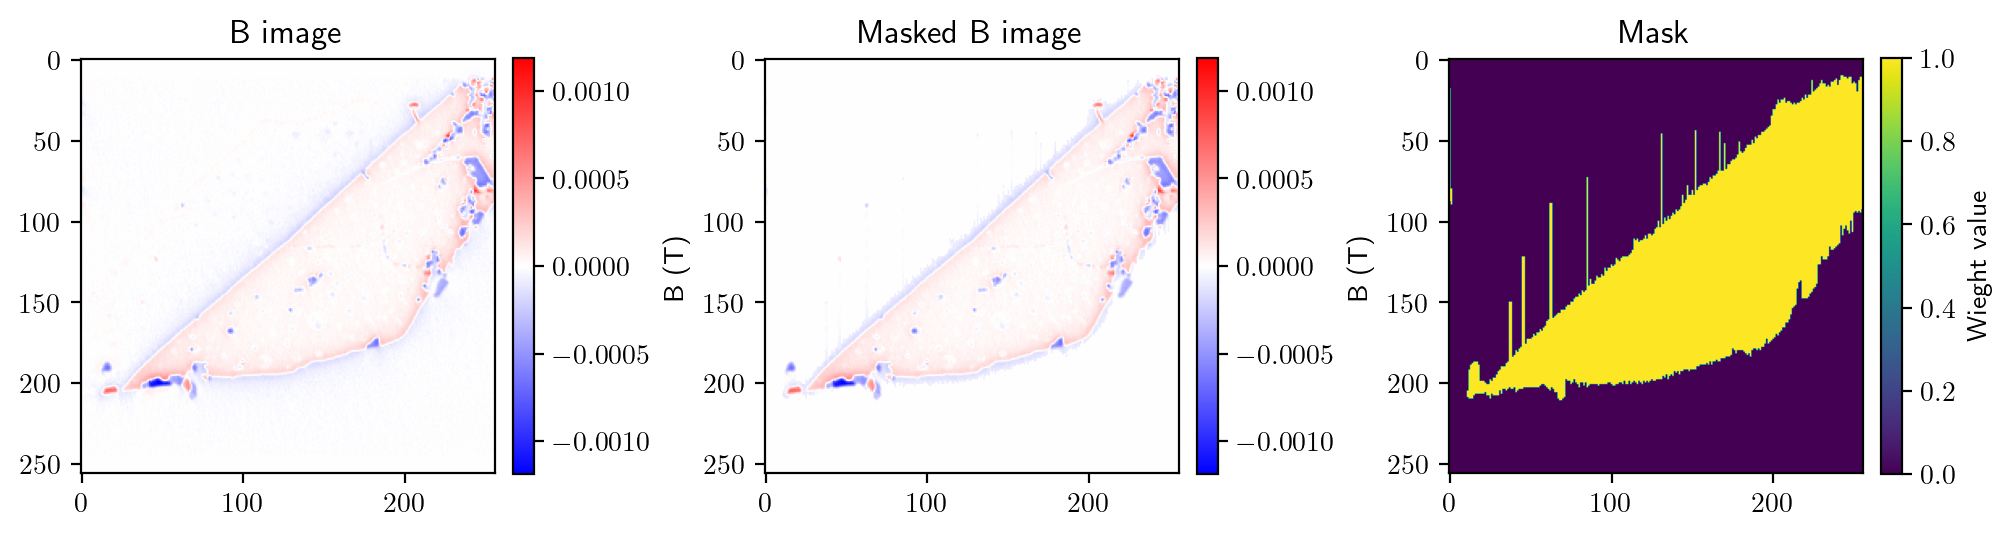

In [42]:
import magrec.image_processing.Masks as masks
# Deifne the source weight
threshold = 0.8e-4
source_weight = masks.mask_vert_dir(dataset.transformed_target[2,::], threshold, plot = True)


# make a new dataset object for the reconstruction
NN_mask_recon_data = Data()
NN_mask_recon_data.load_data(Bz_data, 
                        dx = dx, 
                        dy = dy, 
                        height = height, 
                        theta = 0, 
                        phi = 0, 
                        layer_thickness = 0)

Model = UniformMagnetisation(NN_mask_recon_data, 
                            loss_type = "MSE",  
                            scaling_factor = 1e6,
                            m_theta = 0, 
                            m_phi = 0,             
                            source_weight = source_weight,
                            loss_weight = None, 
                            spatial_filter = False, 
                            spatial_filter_type = "Hanning",
                            spatial_filter_width = [height, height])



FittingMethod_withmask= CNN(Model, learning_rate=0.1)

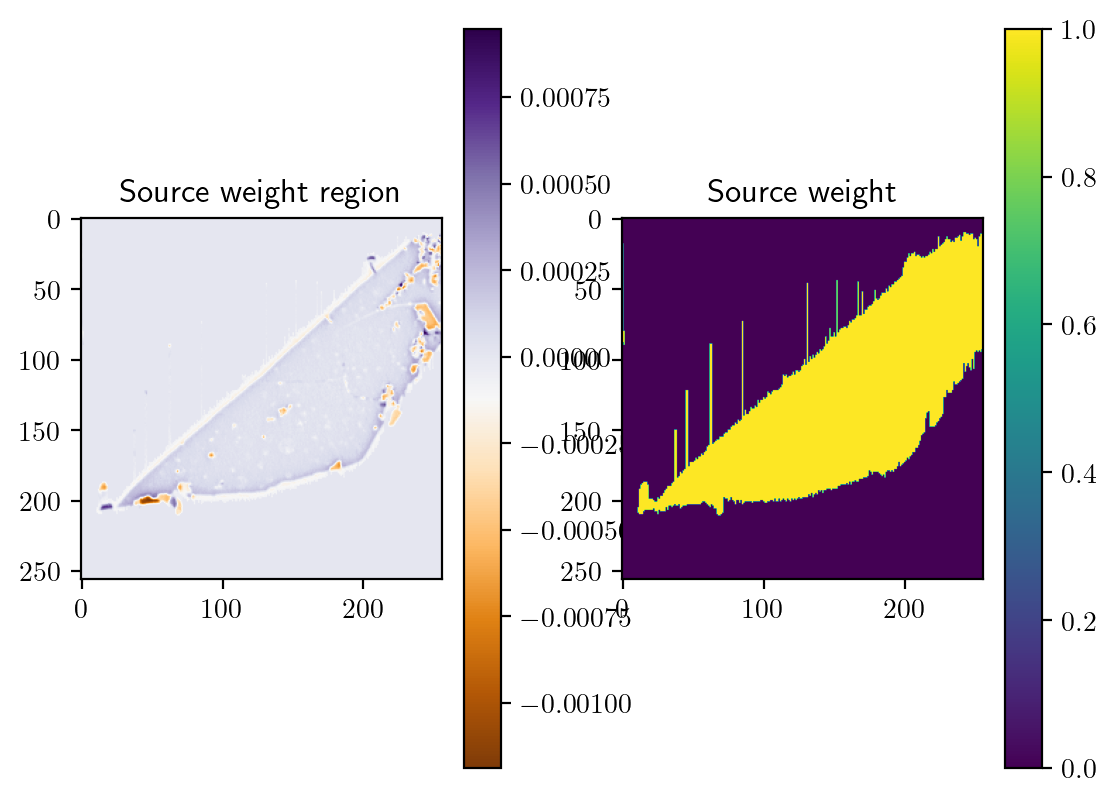

In [43]:
Model.plot_weights()

epoch     1 | loss on last mini-batch:  6.22e+03
epoch    11 | loss on last mini-batch:  6.20e+03
epoch    21 | loss on last mini-batch:  6.07e+03
epoch    31 | loss on last mini-batch:  5.66e+03
epoch    41 | loss on last mini-batch:  4.88e+03
epoch    51 | loss on last mini-batch:  3.98e+03
epoch    61 | loss on last mini-batch:  3.44e+03
epoch    71 | loss on last mini-batch:  2.96e+03
epoch    81 | loss on last mini-batch:  2.73e+03
epoch    91 | loss on last mini-batch:  2.42e+03
epoch   101 | loss on last mini-batch:  2.24e+03
epoch   111 | loss on last mini-batch:  2.10e+03
epoch   121 | loss on last mini-batch:  2.04e+03
epoch   131 | loss on last mini-batch:  1.87e+03
epoch   141 | loss on last mini-batch:  1.81e+03
epoch   151 | loss on last mini-batch:  1.71e+03
epoch   161 | loss on last mini-batch:  1.62e+03
epoch   171 | loss on last mini-batch:  1.87e+03
epoch   181 | loss on last mini-batch:  1.65e+03
epoch   191 | loss on last mini-batch:  1.53e+03
epoch   201 | loss o

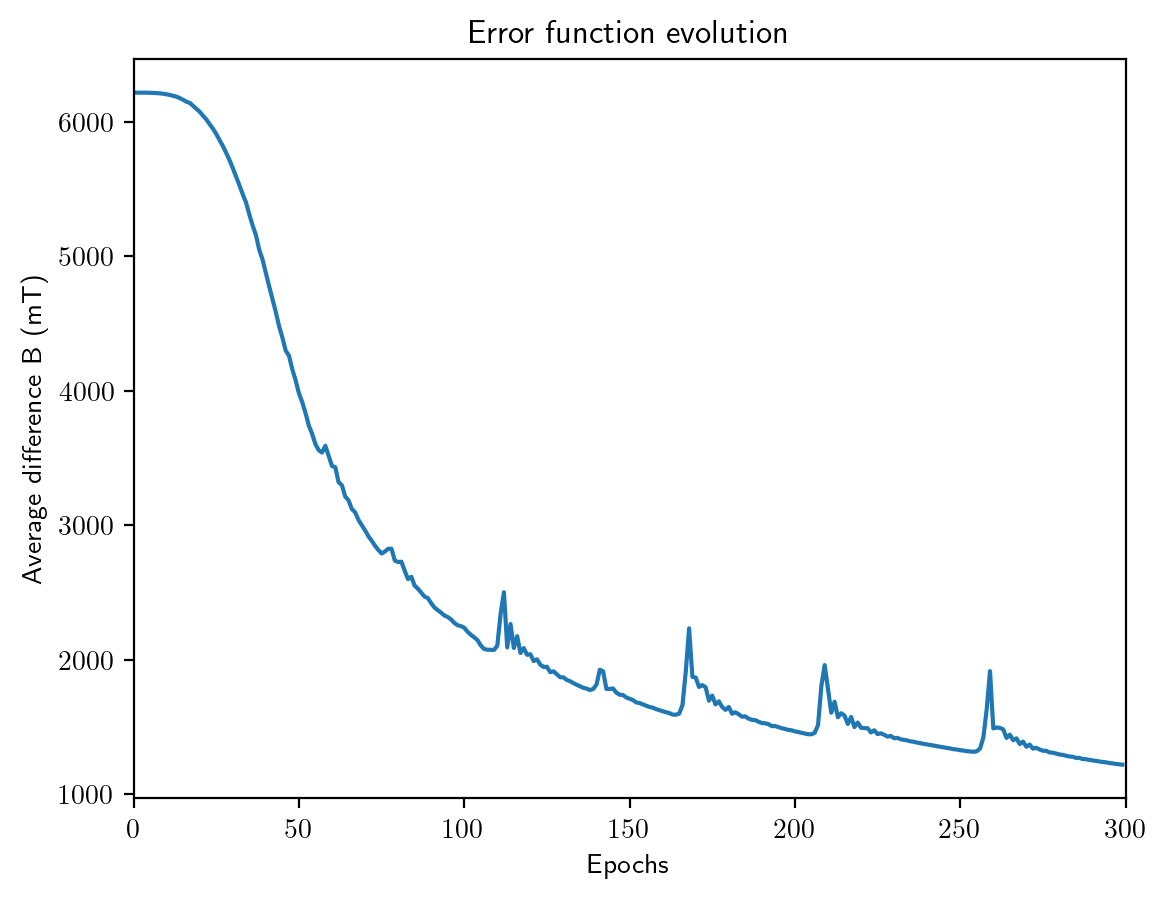

In [44]:
# Perform the fit using the NN
FittingMethod_withmask.fit(n_epochs=300)
# Plot the exvolution of the loss function
FittingMethod_withmask.plot_loss()

Removed the padding that was applied to the data


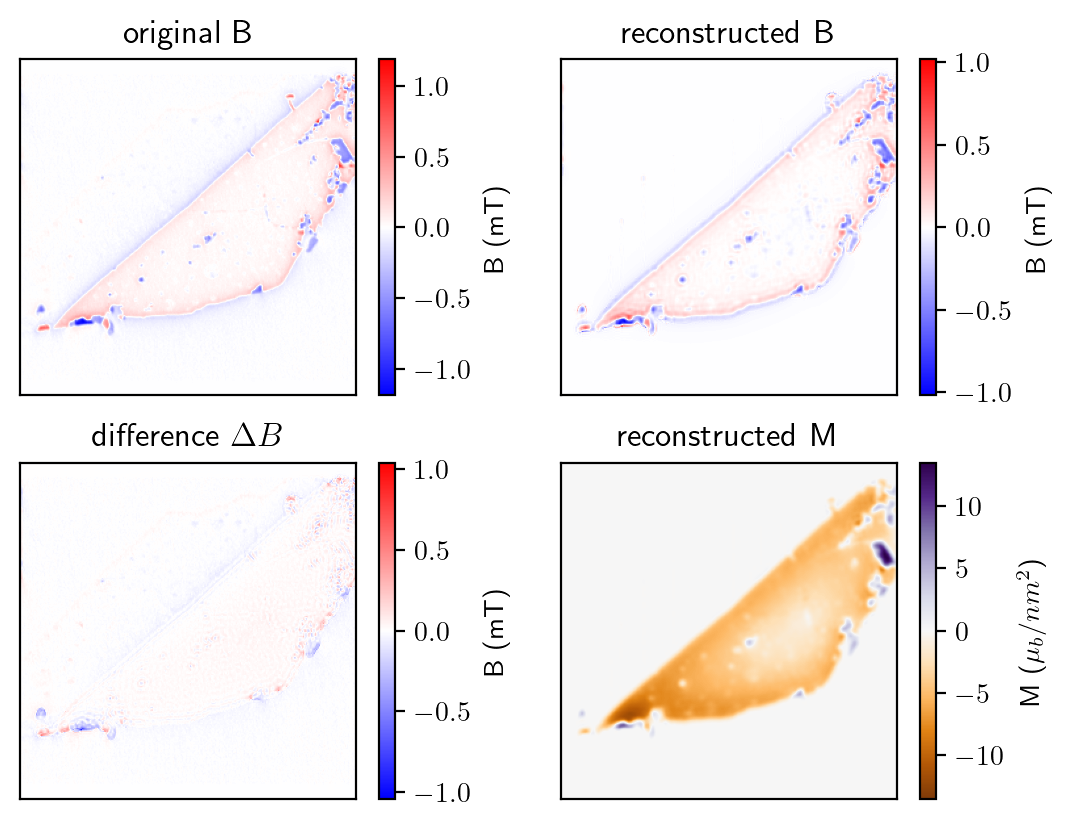

In [45]:
# Plot the results of the reconstruction
FittingMethod_withmask.plot_results()

## 6. Reconstuction with FCNN 

In [46]:
# make a new dataset object for the reconstruction
FCNN_recon_data = Data()
FCNN_recon_data.load_data(Bz_data, 
                        dx = dx, 
                        dy = dy, 
                        height = height, 
                        theta = 0, 
                        phi = 0, 
                        layer_thickness = 0)

# Define the model of the source that will be reconstructed
Model = UniformMagnetisation(NN_recon_data, 
                             loss_type = "MSE", 
                             m_theta = 0, 
                             m_phi = 0,
                             scaling_factor = 1e6,
                             source_weight = source_weight,
                             loss_weight = None, 
                             spatial_filter = True, 
                             spatial_filter_type = "Lorentzian",
                             spatial_filter_width = [2*height, 2*height])

# Define the fitting method and pass it the model
FittingMethod_FCNN = FCNN(Model, learning_rate = 0.1)


Using a Lorentzian filter
Spatial filter implemented into the model with a width of 1.20 and 1.20 pixels or 0.060 um.
Number of sources: 1
Number of targets: 1
Including source angles in the neural network: False


c:\Users\E123108\AppData\Local\anaconda3\envs\magrec\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


C:\Users\E123108\Dropbox\Programming\Python\magrec\src\magrec\models\UniformMagnetisation.py:248: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return torch.nn.functional.conv2d(input_tensor, weight=kernel, groups=channels, stride=1, padding="same")


epoch     1 | loss on last mini-batch:  6.22e+03
epoch    26 | loss on last mini-batch:  5.49e+03
epoch    51 | loss on last mini-batch:  1.58e+03
epoch    76 | loss on last mini-batch:  9.78e+02
epoch   101 | loss on last mini-batch:  8.35e+02
epoch   126 | loss on last mini-batch:  7.57e+02
epoch   151 | loss on last mini-batch:  7.08e+02
epoch   176 | loss on last mini-batch:  6.79e+02
epoch   201 | loss on last mini-batch:  6.64e+02
epoch   226 | loss on last mini-batch:  6.58e+02
epoch   251 | loss on last mini-batch:  6.56e+02
epoch   276 | loss on last mini-batch:  6.56e+02


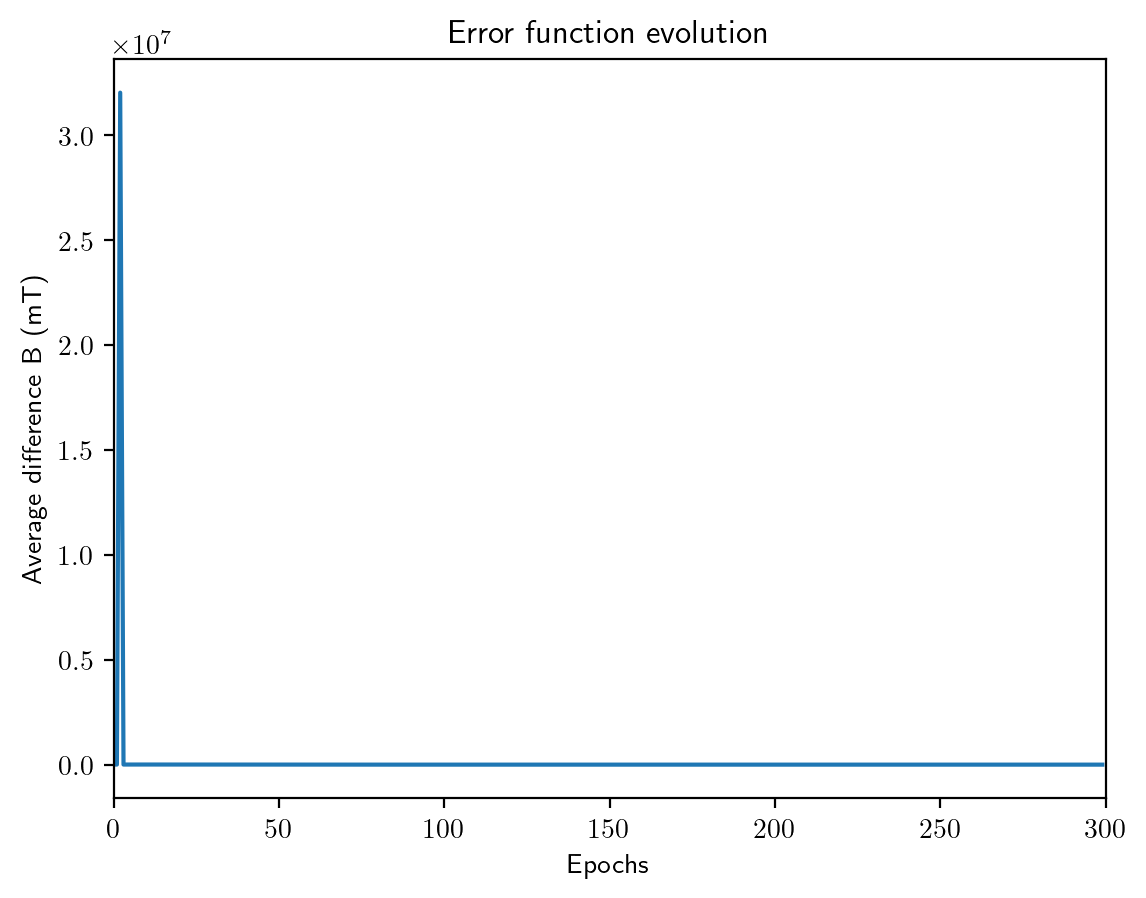

In [47]:


# Perform the fit using the NN
FittingMethod_FCNN.fit(n_epochs=300)


# Plot the exvolution of the loss function
FittingMethod_FCNN.plot_loss()


Removed the padding that was applied to the data


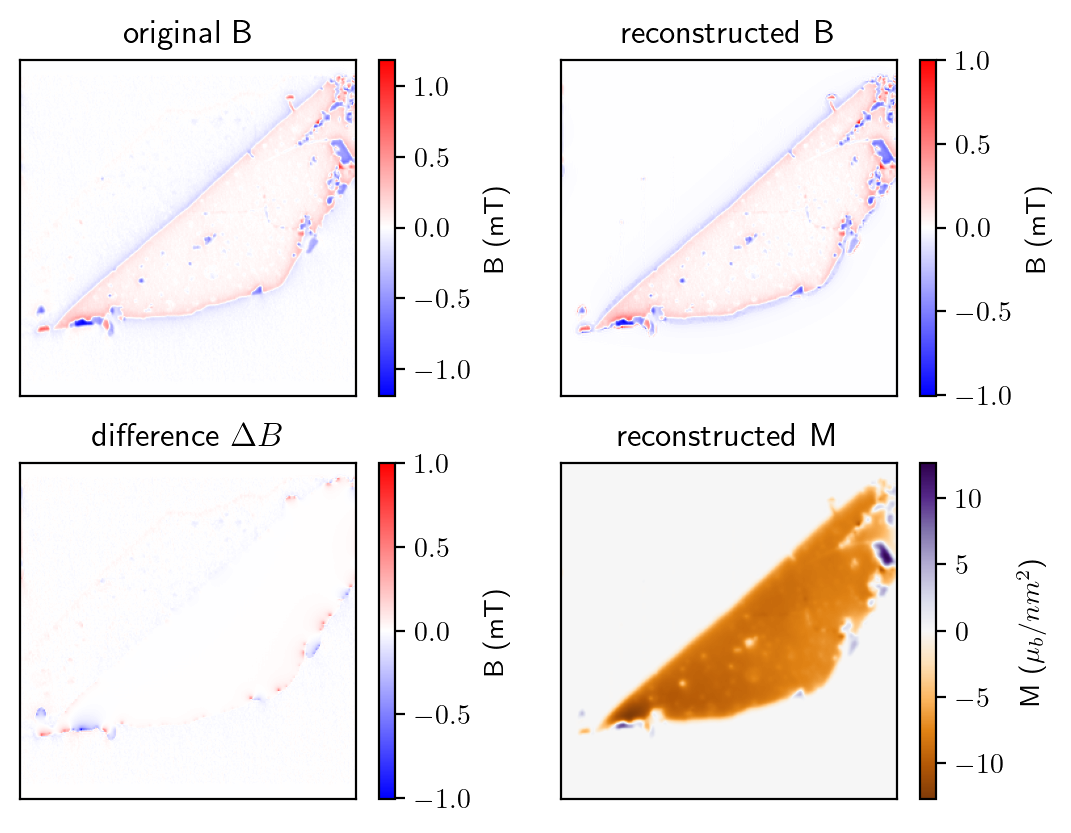

In [48]:
FittingMethod_FCNN.plot_results()

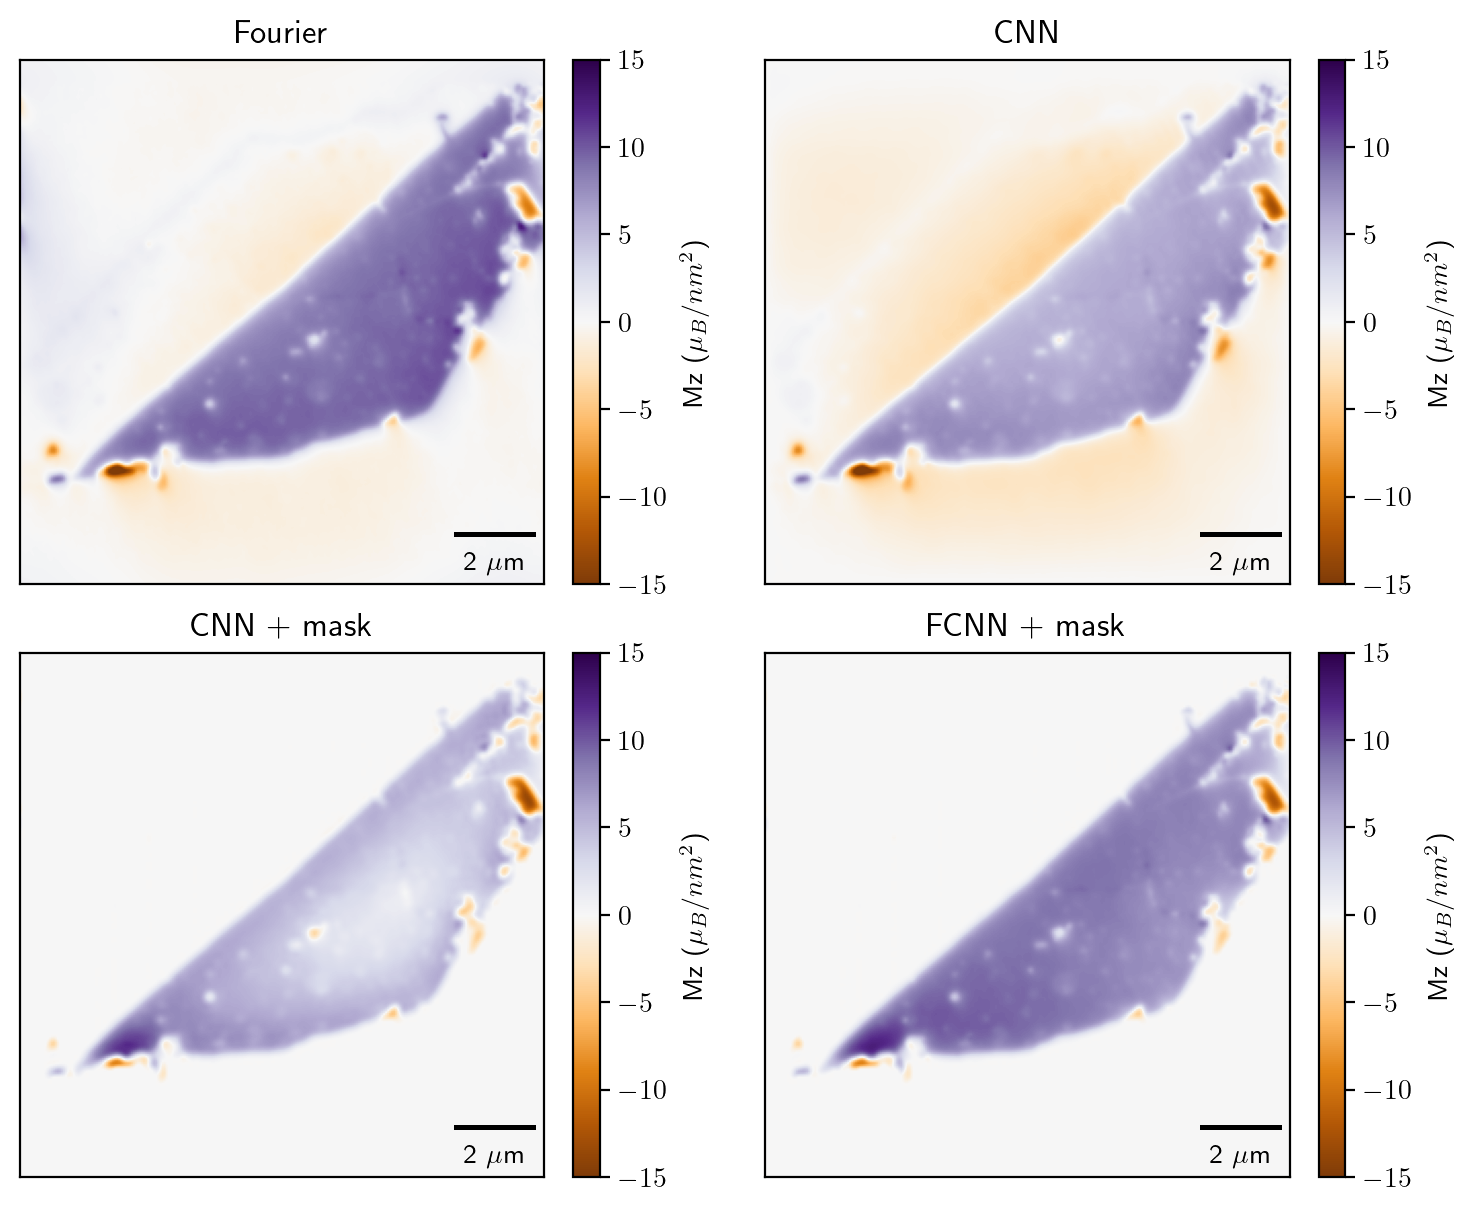

In [66]:
# Sompare the results of all the different reconstructions
from matplotlib_scalebar.scalebar import ScaleBar

plt.figure(figsize=(8, 6))


plt.subplot(2,2,1)
plt.imshow(-1*Frecon_bz_dataset.transformed_target + 2, cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Fourier")
plt.xticks([])
plt.yticks([])
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('Mz ($\mu_B/nm^2$)')
# add a scale bar
scalebar = ScaleBar(dx, units="um", location = "lower right", frameon=False) 
plt.gca().add_artist(scalebar)


plt.subplot(2,2,2)
plt.imshow(-1*FittingMethod.results["Magnetisation"] , cmap="PuOr", vmin=-15, vmax = 15)
plt.title("CNN")
plt.xticks([])
plt.yticks([])
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('Mz ($\mu_B/nm^2$)')
scalebar = ScaleBar(dx, units="um", location = "lower right", frameon=False) 
plt.gca().add_artist(scalebar)

plt.subplot(2,2,3)
plt.imshow(-1*FittingMethod_withmask.results["Magnetisation"] , cmap="PuOr", vmin=-15, vmax = 15)
plt.title("CNN + mask")
plt.xticks([])
plt.yticks([])
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('Mz ($\mu_B/nm^2$)')
scalebar = ScaleBar(dx, units="um", location = "lower right", frameon=False) 
plt.gca().add_artist(scalebar)

plt.subplot(2,2,4)
plt.imshow(-1*FittingMethod_FCNN.results["Magnetisation"] , cmap="PuOr", vmin=-15, vmax = 15)
plt.title("FCNN + mask")
plt.xticks([])
plt.yticks([])
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('Mz ($\mu_B/nm^2$)')
scalebar = ScaleBar(dx, units="um", location = "lower right", frameon=False) 
plt.gca().add_artist(scalebar)

# increase the horizontal space between subplots
plt.tight_layout(pad=0.5)



In [61]:
dx

0.049999999999999996